#### <p style='text-align: left;'>Nicolò Malatesta<br><br>Raffaele William D'Agostino</p>
#### <p style='text-align: right;'>Fundamentals of Information Systems<br><br>2020/2021</p>
# <p style='text-align: center;'>A Song for You</p>

# 0. Introduction

In the following notebook we are going to work with music data, more specifically we are going to use data provided by Spotify (one of the most popular music streaming services in the world) to build a song recommendation tool based on user preferences. For this task we will use two datasets, one focusing on songs peculiarities and the other on artists traits (we will mainly need the music genres associated with a given artist). We were provided some other datasets, which contained the same data grouped by years, artists and genres, but for this project we think that these are not really useful since we are just focusing on songs, and we already have all the data we need in the two dataframes we just mentioned. The ultimate goal of this project is to take raw user data and find a way to exploit it with the scope of building a functional recommender system, which utilizes information about the user's preferences to suggest him new songs he might be interested in.

For this project we will need numpy to generate random values for our users, pandas to deal with dataframes, matplotlib for data vizualization, sklearn to build our recommender system and IPyhton to embed the songs from spotify into the notebook. 

In [1]:
import numpy as np
import pandas as pd
import sklearn.metrics.pairwise as pw
from matplotlib import pyplot as plt
from IPython.display import HTML

# 1. Dataframes

Our first step in building our recommender system is to load the data. For this project we will use two datasets:
- A dataset focusing on the features of the various songs
- A dataset focusing on the features of the various artists

The first one will be our main dataframe (the one we will use for our recommendations), while the second one is crucial because it contains information about the music genres associated with a specific artist, which is something that we will need in order to give the user more accurate suggestions. So we start this project by importing these two datasets.

### 1.1 Songs Dataframe

In [2]:
df = pd.read_csv('.\data.csv', converters={'artists': eval})
print('This Dataframe contains {} songs and {} features.'.format(df.shape[0], df.shape[1]))
df.head()

This Dataframe contains 169909 songs and 19 features.


,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.995,[Carl Woitschach],0.708,158648,0.1950,0,6KbQ3uYMLKb5jDxLF7wYDD,0.563,10,0.1510,-12.428,1,Singende Bataillone 1. Teil,0,1928,0.0506,118.469,0.7790,1928
1,0.994,"[Robert Schumann, Vladimir Horowitz]",0.379,282133,0.0135,0,6KuQTIu1KoTTkLXKrwlLPV,0.901,8,0.0763,-28.454,1,"Fantasiestücke, Op. 111: Più tosto lento",0,1928,0.0462,83.972,0.0767,1928
2,0.604,[Seweryn Goszczyński],0.749,104300,0.2200,0,6L63VW0PibdM1HDSBoqnoM,0.000,5,0.1190,-19.924,0,Chapter 1.18 - Zamek kaniowski,0,1928,0.9290,107.177,0.8800,1928
3,0.995,[Francisco Canaro],0.781,180760,0.1300,0,6M94FkXd15sOAOQYRnWPN8,0.887,1,0.1110,-14.734,0,Bebamos Juntos - Instrumental (Remasterizado),0,1928-09-25,0.0926,108.003,0.7200,1928
4,0.990,"[Frédéric Chopin, Vladimir Horowitz]",0.210,687733,0.2040,0,6N6tiFZ9vLTSOIxkj8qKrd,0.908,11,0.0980,-16.829,1,"Polonaise-Fantaisie in A-Flat Major, Op. 61",1,1928,0.0424,62.149,0.0693,1928


### 1.2 Artists Dataframe

In [3]:
df_genres = pd.read_csv('.\data_w_genres.csv', converters={'genres': eval})
print('This Dataframe contains {} artists and {} features.'.format(df_genres.shape[0], df_genres.shape[1]))
df_genres.head()

This Dataframe contains 27621 artists and 16 features.


,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count,genres
0,"""Cats"" 1981 Original London Cast",0.575083,0.442750,247260.000000,0.386336,0.022717,0.287708,-14.205417,0.180675,115.983500,0.334433,38.000000,5,1,12,[show tunes]
1,"""Cats"" 1983 Broadway Cast",0.862538,0.441731,287280.000000,0.406808,0.081158,0.315215,-10.690000,0.176212,103.044154,0.268865,33.076923,5,1,26,[]
2,"""Fiddler On The Roof” Motion Picture Chorus",0.856571,0.348286,328920.000000,0.286571,0.024593,0.325786,-15.230714,0.118514,77.375857,0.354857,34.285714,0,1,7,[]
3,"""Fiddler On The Roof” Motion Picture Orchestra",0.884926,0.425074,262890.962963,0.245770,0.073587,0.275481,-15.639370,0.123200,88.667630,0.372030,34.444444,0,1,27,[]
4,"""Joseph And The Amazing Technicolor Dreamcoat""...",0.605444,0.437333,232428.111111,0.429333,0.037534,0.216111,-11.447222,0.086000,120.329667,0.458667,42.555556,11,1,9,[]


# 2. EDA
Before we start visualising our data, we need to understand what some of these features represent. While some of them are pretty much self explanatory (danceability, duration, etc.), there are some variables that need to be addressed beforehand. These include <i>explicit</i>, <i>key</i>, and <i>mode</i>. <i>Explicit</i> is just a binary feature that tells us if a song's lyrics contain explicit language or not, <i>key</i> is a categorical variable indicating the scale of a song (which is beyond the purpose of this project) and <i>mode</i> is another binary feature that expands on the concept of key (0 indicates a 'minor' mode, which is often used for sad and melancholic songs, while 1 indicates a 'major' key, often used for happier songs).

We can now proceed to explore our main dataset in order to obtain more information on the features concerning every song. Below we can see histograms for each numeric feature of our dataset. These can help us get more knowledge about each variable and its distribution.

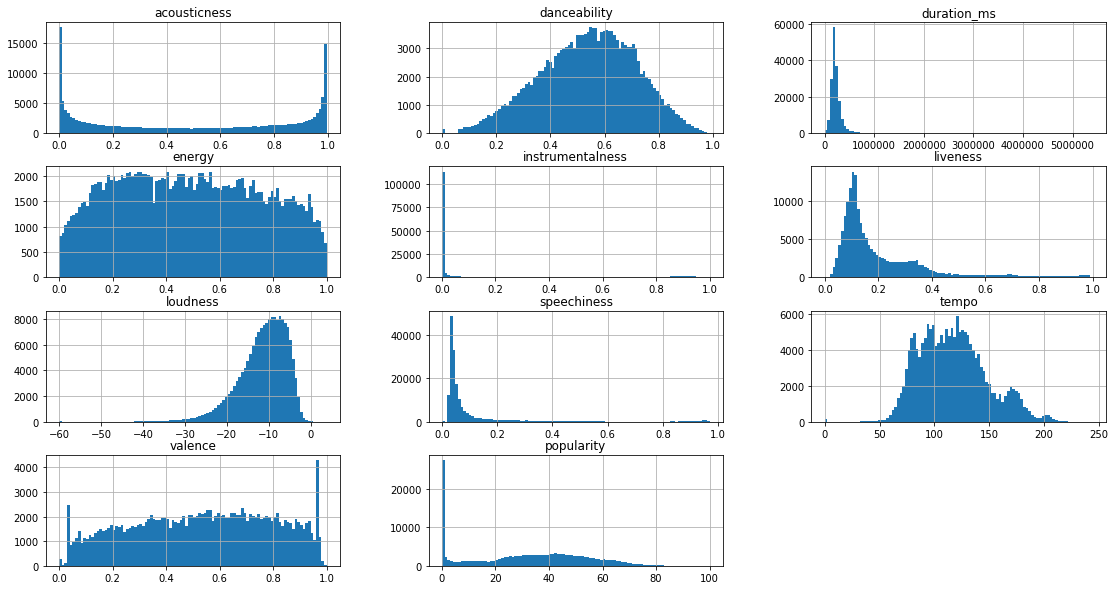

In [4]:
filtred_cols = ['acousticness','danceability', 'duration_ms','energy','instrumentalness','liveness','loudness','speechiness','tempo','valence','popularity']
df.hist(figsize=(19,10), bins=100, column=filtred_cols)
plt.show()

As we said, our features have different scopes and we can see that they follow different distributions. For example, variables like <b><code>danceability</code></b>, <b><code>liveness</code></b>, <b><code>loudness</code></b> and <b><code>tempo</code></b> seem to be normally distributed, although a bit skewed in some cases. Then we have some more uniformally distributed variables such as <b><code>energy</code></b>, <b><code>popularity</code></b> and <b><code>valence</code></b>. Finally we have binary (or very close to being binary) features like <b><code>explicit</code></b>, <b><code>mode</code></b> and <b><code>acousticness</code></b> (where we can see that most of the observations lie near 0 and 1), along with features that concentrate most of their observations in a small range of values (<b><code>duration_ms</code></b>, <b><code>instrumentalness</code></b> and <b><code>speechiness</code></b>). These last three could be problematic for our task, as we will see later, since they tend to be very similar for every song and could cause some unnecessary bias in our algorithm. Also, something like the <b><code>key</code></b> of a song could very possibly be irrelevant for our project, since it is a technical variable that is almost impossible for a casual listener to distinguish. In the next sections, after finding our preferred algorithm, we will take into consideration some of these information to select the features that provide the best recommendations.

# 3. Data cleaning and preparation
In this section we will deal with the manipulation and organization of our data in order to prepare it for our ML process. We adjust our dataset to best meet our needs and handle missing values, feature selection, etc. Also, for this project we would need to have user data (information on which songs a user has listened to, how many times they are listened to, etc.), but this data is not found in the datasets. To solve this issue, we randomly generate user profiles enriching them with data we have available.

### 3.1 Preparing our dataset
#### 3.1.1 Adding the genres of a song
Since our goal is to recommend songs based on a user's preferences, we need to use the features that approximate those preferences best. While our dataset already contains plenty of those, we think that a key variable is missing from our dataset: the <b>genre</b> of a song. Knowing the genre of each song in our dataset will allow us to execute a faster and more precise search of the tracks that are the most similar to the user's favourite songs. After all, even if the other features suggest similarity, we don't want to recommend classical songs to an heavy metal fan. <br>
We will therefore use our <b><code>df_genres</code></b> dataset to obtain information about songs genres. For each song we are going to assign up to three genres, giving us a more broad perception of a song's style and influences.

<b>Disclaimer:</b> the following cell takes a couple of minutes to run, if you prefer you can just skip it and easily load the data obtained by running the cell after this one (which loads the csv file we provided).

In [88]:
# we create a copy of the songs dataframe 
df_new = df.copy()

# First we create a list that will contain each song's genres 
# Then 3 other lists that will contain respectively each song's first, second and third genre
songs_genres = []

songs_genre1 = []
songs_genre2 = []
songs_genre3 = []

for i, row in df.iterrows():
    
    # we try to select the lead artist's genres for every song. (artists[0])
    # in case of a missing value we will select the first featured artist's genres. (artists[1])
    
    try:
        songs_genres.append(df_genres[df_genres.artists == row.artists[0]]['genres'].values[0])
        
    except:
        songs_genres.append(df_genres[df_genres.artists == row.artists[1]]['genres'].values[0])
    
    
    # some artists have no genres attached to their profile, we will assign a None value to those for every genre column
    if not songs_genres[i]:
        songs_genre1.append(None)
        songs_genre2.append(None)
        songs_genre3.append(None)
    
    # We then assign the 1st, 2nd and 3rd genre to their respective columns,
    # giving None values to the 2nd and 3rd for songs with just 1 or 2 genres
    else:
        songs_genre1.append(songs_genres[i][0])
        
        try:
            songs_genre2.append(songs_genres[i][1])
        except:
            songs_genre2.append(None)
        
        try:
            songs_genre3.append(songs_genres[i][2])
        except:
            songs_genre3.append(None)

# we check that our songs' genre list has the same amount of records as the songs dataframe
print('We have {} rows in our dataframe and {} items in our list.'.format(len(df_new), len(songs_genres)))

# finally we create 3 new columns containing our data in our new dataset
# and we drop every record that doesn't contain at least 1 genre
df_new['genre1'] = songs_genre1
df_new['genre2'] = songs_genre2
df_new['genre3'] = songs_genre3

df_new = df_new[(df_new.genre1.isnull() == False)].reset_index(drop=True)

#df_new.to_csv('data_new.csv', index=False)

We have 169909 rows in our dataframe and 169909 items in our list.


In [2]:
df_new = pd.read_csv('./data_new.csv', converters = {'artists' : eval})

#### 3.1.2 Adding the "decade" of a song
Another very common practice that usually comes up when you're dealing with music is to divide its timeline in "<i>eras</i>". Everyday we hear people talk about how music was better in their time, so we want to take that into consideration when we recommend new songs. So, in order to do that, we are going to form groups of decades by grouping together all the years that are contained in each decade.

In [3]:
decades = [1920,1930,1940,1950,1960,1970,1980,1990,2000,2010,2021]
labels = ["20's","30's","40's","50's","60's","70's","80's","90's","2000's","2010 to 2020"]

df_new['decade'] = pd.cut(df_new.year, bins=decades, labels=labels, right= False)

Our dataset is finally ready to be used for our task, and it now looks like this:

In [4]:
df_new.head()

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,...,popularity,release_date,speechiness,tempo,valence,year,genre1,genre2,genre3,decade
0,0.994,"[Robert Schumann, Vladimir Horowitz]",0.379,282133,0.0135,0,6KuQTIu1KoTTkLXKrwlLPV,0.901,8,0.0763,...,0,1928,0.0462,83.972,0.0767,1928,classical,early romantic era,NaN,20's
1,0.995,[Francisco Canaro],0.781,180760,0.1300,0,6M94FkXd15sOAOQYRnWPN8,0.887,1,0.1110,...,0,1928-09-25,0.0926,108.003,0.7200,1928,tango,vintage tango,NaN,20's
2,0.990,"[Frédéric Chopin, Vladimir Horowitz]",0.210,687733,0.2040,0,6N6tiFZ9vLTSOIxkj8qKrd,0.908,11,0.0980,...,1,1928,0.0424,62.149,0.0693,1928,classical,early romantic era,polish classical,20's
3,0.995,"[Felix Mendelssohn, Vladimir Horowitz]",0.424,352600,0.1200,0,6NxAf7M8DNHOBTmEd3JSO5,0.911,6,0.0915,...,0,1928,0.0593,63.521,0.2660,1928,classical,early romantic era,NaN,20's
4,0.956,"[Franz Liszt, Vladimir Horowitz]",0.444,136627,0.1970,0,6O0puPuyrxPjDTHDUgsWI7,0.435,11,0.0744,...,0,1928,0.0400,80.495,0.3050,1928,classical,late romantic era,NaN,20's


### 3.2 Generating users data
In order to start working on a recommendation algorithm we need some users' data. Since we don't have that, we are going to randomly generate 10 mock user profiles using the data we possess. Moreover, we are going to generate a new feature that will let us know how many times an user listened to a specific song. If we had real users' data this would be, for every song, the total amount of milliseconds played by a user divided by the song's duration in milliseconds: <br><br>

\begin{equation}
{\bf times \: played \: = \:} {{\bf total \: ms \: played} \over {\bf duration \: ms}}
\end{equation}

<br>

In [5]:
# We don't have user's specific data, so we randomly generate 10 mock users profiles from our dataset
users = []

for i in range(10):
    # We set a different random seed for each iteration of the loop in order to obtain users with unique data
    np.random.seed(i+10)
    
    # We select 1000 random rows of our songs' dataset and we assign them to a new user 
    idx = np.random.choice(df_new.index,size=1000)
    users.append(df_new.loc[idx, :])
    
    # We randomly generate a variable telling us how many times an user played each song 
    times_played = np.random.chisquare(3,size=1000)
    users[i]['times_played'] = times_played


We can take a look at our first mock user's dataframe:

In [6]:
users[0].head()

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,...,release_date,speechiness,tempo,valence,year,genre1,genre2,genre3,decade,times_played
83209,0.8320,[Martin Denny],0.454,186480,0.182,0,0X7UYBmyyXyZovNJoT0Lzr,0.009700,7,0.2000,...,1958-01-01,0.0464,142.858,0.0764,1958,adult standards,easy listening,exotica,50's,1.395502
94735,0.0137,"[Eazy-E, Dr. Dre]",0.866,219947,0.818,1,5jG3djnKEjdcJwidjYWtxL,0.000000,8,0.1320,...,1988-09-13,0.2600,103.332,0.7470,1988,g funk,gangster rap,hardcore hip hop,80's,3.293403
93553,0.6220,[Jefferson Starship],0.536,216240,0.527,0,62NJcC5piTuieIFiDZxiz1,0.000334,2,0.0937,...,1976-01-01,0.0327,121.297,0.4800,1976,album rock,art rock,classic rock,70's,3.554945
105595,0.0946,"[K CAMP, Fetty Wap]",0.785,215573,0.413,1,4immekPm8Har57BB9DcDSj,0.000000,4,0.1260,...,2014-09-04,0.1510,87.529,0.4550,2014,atl hip hop,deep pop r&b,hip hop,2010 to 2020,1.603095
9372,0.5720,"[John Mayall & The Bluesbreakers, Eric Clapton]",0.587,180667,0.490,0,66EJzuzUOkBjeJunT7RMGN,0.004050,0,0.2180,...,1966-06-22,0.0264,82.357,0.4830,1966,blues,blues rock,british blues,60's,2.355411


# 4. Model and Features selection
We have finally obtained and organized all the data we need, so we can now start thinking about what kind of algorithm we want to deploy to build our recommender system. In an ideal situation we would choose between any of the typical train/test supervised ML models and compare its performance to the others', eventually selecting the best performing one. However, as we said before, we do not possess real users' data, and the approach we just illustrated isn't really feasible with our randomly generated data (for example, in the real world the genres of the most listened songs for a specific user would be much more homogeneous compared to our randomly generated counterpart, making real users a lot easier to profile). That said, we can approach our data with a different mindset, going for a more <b>content based</b> algorithm, which allows us to base our recommendations on the "<i><b>similarity</b></i>" between the features of the user's favourite tracks and the songs we want to recommend. As an approximation of the user's favourite songs we are going to use the five tracks that he listened to the most, so the five songs with the highest <code><b>times_played</b></code> values. <br>
For this purpose, we are going to use a scoring method called "<i><b>cosine similarity</b></i>", which compares each song in our dataset to the most listened songs for a user and assigns them a "similarity score" between -1 and 1 using this formula:<br><br>

\begin{equation}
\cos ({\bf X},{\bf Y})= {{\bf X} {\bf Y} \over \|{\bf X}\| \|{\bf Y}\|} = \frac{ \sum_{i=1}^{n}{{\bf X}_i{\bf Y}_i} }{ \sqrt{\sum_{i=1}^{n}{({\bf X}_i)^2}} \sqrt{\sum_{i=1}^{n}{({\bf Y}_i)^2}} }
\end{equation}

<br><br>
where <b>X</b> and <b>Y</b> are respectively the matrixes of the features of our dataset's songs and those of the user's favourite ones.

After choosing our preferred algorithm, it is now time to find which features give us the best results. In our case this is really hard to do, since measuring performance on randomly generated user data isn't really feasible (we are just simulating a supervised learning environment, but in our case there are no patterns that lead to some songs being more listened than others). With that said, we can still work with what we have and find what features work best for our 10 mock users. To do that, first we calculate for each user the <b><i>minimum</i></b> and the <b><i>mean</i></b> of the similarity scores we obtained, then we compute the averages of these two measures for all users. We repeat this process starting from a model with just the first two features, to the model containing every feature we have, and we then compare the results we obtained for every model. This will let us see, on average, the changes that each new variable causes to the similarity scores, which will give us an idea of the impact that each feature has on the similarity between songs. One thing to note is that we will exclude the <code><b>key</b></code> variable for the reason we explained in the EDA section (being irrelevant to the listener), and we will put the features that we deemed to potentially be problematic at the end of the list, so that it is easier to see their impact on the model.

In [7]:
# First we define a function that takes as input a user dataframe
# and the index of the last column we want to include in our model
# The function will then return a tuple with the minimum and mean of the similarity scores

def songsRecommenderTesting(user, excluding):
    
    
    # We now isolate the 5 most listened track for our user, which we will then use to make our recommendations
    top5 = user.sort_values(by='times_played',ascending=False).head().reset_index(drop=True)
    
    # We now need to obtain our X and Y features matrixes,
    # for which we will only need the numerical variables of the two dataframes
        
    column_names = ['acousticness', 'danceability', 'energy','valence',
                    'loudness','tempo','popularity','instrumentalness',
                    'speechiness','mode','explicit','liveness','duration_ms']
        
    top_matrix = top5[column_names].to_numpy()
        
    df_matrix = df_new[column_names].to_numpy()
    
    # At this point, we can start implementing our cosine similarity algorithm to each of the user's top songs
    for idx in range(len(top5)):      

        # Finally, we deploy the cosine similarity algorithm and we obtain a similarity matrix
        # We only store the column concerning the user track we're considering in our loop (since we only want to search 
        # in a specific genre subset for each user top song)
        
        cos_sim = pd.Series(pw.cosine_similarity(df_matrix[:, :excluding], top_matrix[:, :excluding])[:,idx])
        
        return (cos_sim.min(), cos_sim.mean())
        

In [8]:
# Now we compute the averages for every user and for every model and we print the results

for i in range(2,14):
    
    cs_min = []
    cs_mean = []
    
    for user in users:
        
        results = songsRecommenderTesting(user, i)
        cs_min.append(results[0])
        cs_mean.append(results[1])
        
    print('Using the first {} features:'.format(i), (sum(cs_min)/len(cs_min), sum(cs_mean)/len(cs_mean)))
    

Using the first 2 features: (0.0, 0.8116070926662674)
Using the first 3 features: (0.0, 0.7794968924449928)
Using the first 4 features: (0.0, 0.7969088815142069)
Using the first 5 features: (-0.9357542714968649, 0.9904075096410117)
Using the first 6 features: (0.0817142347096692, 0.9945420281424994)
Using the first 7 features: (0.07619951179870335, 0.9713810990002857)
Using the first 8 features: (0.0762011082165158, 0.9713676644938269)
Using the first 9 features: (0.07620052387170949, 0.9713634718289972)
Using the first 10 features: (0.076198713555745, 0.9713409768966239)
Using the first 11 features: (0.076198713555745, 0.971338446558313)
Using the first 12 features: (0.07618510510290896, 0.971336583860503)
Using the first 13 features: (0.9999314496281981, 0.9999999011428192)


These results show us that there are some very intersting things happening. We can see that up until the model with the first 7 features, every model seem to have reasonably different minimum and mean similarity averages, suggesting that each of those features has a significant impact on them. Then, from the model with the first 8 features to the one with every feature but the last, the averages remain very close to each other, which is an indicator of variables that don't seem to be statistically relevant to our task. Unsurprisingly, most of these features are the ones that we predicted to be problematic in our EDA section (<b><i>instrumentalness, speechiness, mode, explicit</i></b>). If we then add the last variable (<b><i>duration_ms</i></b>, another one that we deemed problematic) we obtain unreasonably high values, which could lead to very high bias causing our model to consider each song to be approximately equal to all other songs. For this reasons, we decide to exclude the last six features from our model and only keep the first seven (<b><i>acousticness, danceability, energy, valence, loudness, tempo, popularity</i></b>), allowing us to get the best results with as few variables as possible.

# 5. Model application and results

We have finally reached the end of this project: we selcted our model and we found the best features for this task. Now it is just a matter of implementing our cosine similarity algorithm, use it to build a song recommender system and then check the results. For each song in a user's top 5, our algorithm will look through every track with the decade and at least one genre in common, and it will select and recommend the song with the highest similarity score.

In [9]:
# We build a function that takes as input a user dataframe,
# prints his top 5 songs and returns 5 recommended songs in a new dataframe

def songsRecommender(user):
    
    # These are the features we are going to feed to our model
    column_names = ['acousticness', 'danceability', 'energy',
                    'valence','loudness','tempo','popularity']
    
    # These are the columns we want to show in our results
    datasets_columns = ['artists','name','acousticness','danceability','energy','valence',
                        'loudness','tempo','popularity','decade','genre1','genre2','genre3','id']
    
    # We create an empty dataframe. We will later insert our recommendation here
    recommendations = pd.DataFrame(columns = df_new.columns)
    
    # We now isolate and display the 5 most listened track for our user, which we will then use to make our recommendations
    top5 = user.sort_values(by='times_played',ascending=False).head().reset_index(drop=True)
    print('These are your 5 most listened songs:')
    display(top5[datasets_columns])
    
    # We create the features matrix for the user's top songs
    top_matrix = top5[column_names].to_numpy()
    
    # We store some additional masking that we will use to filter the songs based on genre
    nan_filter_2 = df_new.genre2.notnull()
    nan_filter_3 = df_new.genre3.notnull()
    
    # At this point, we can start implementing our cosine similarity algorithm to each of the user's top songs
    
    for idx in range(len(top5)):
        
        # We start by creating a subset of our songs dataframe which only contains  
        # songs with at least 1 of the 3 genres (!= None) and the decade in common with the user track we are considering        
                    
        genre_mask = ((df_new.genre1 == top5.iloc[idx].genre1) | (df_new.genre1 == top5.iloc[idx].genre2) | 
                      (df_new.genre1 == top5.iloc[idx].genre3) | ((df_new.genre2 == top5.iloc[idx].genre1) & nan_filter_2) |
                      ((df_new.genre2 == top5.iloc[idx].genre2) & nan_filter_2) | ((df_new.genre2 == top5.iloc[idx].genre3) & nan_filter_2) |
                      ((df_new.genre3 == top5.iloc[idx].genre1) & nan_filter_3) | ((df_new.genre3 == top5.iloc[idx].genre2) & nan_filter_3) |
                      ((df_new.genre3 == top5.iloc[idx].genre3) & nan_filter_3))
        
        subset = df_new[genre_mask & (df_new.decade == top5.iloc[idx].decade)]
        
        # We create the features matrix of our subset
                       
        df_matrix = subset[column_names].to_numpy()

        # Finally, we deploy the cosine similarity algorithm and we obtain a similarity matrix
        # We only store the column concerning the user track we're considering in our loop (since we only want to search 
        # in a specific genre subset for each user top song)
        
        cos_sim = pd.Series(pw.cosine_similarity(df_matrix, top_matrix)[:,idx])
        
        # The last thing we need to consider is that we only want to recommend songs that the user hasn't already listened
        
        # Since the considered track's most similar song is obviously that track itself,
        # we will start our loop from the song with the second highest similarity score 
        i = 1
        
        while(i<len(df_new)):
            
            # We now obtain the df_new index value of our most similar song
            
            subset_idx = cos_sim.sort_values(ascending=False).index[i]
            df_idx = subset.iloc[subset_idx].name
            
            # Then we check if that song has already been listened by our user
            # If he has never listened to it, we insert it into our recommendation dataframe and exit the loop
            # Otherwise we get the next most similar song and we repeat the process until we find one he didn't listen
            
            if df_idx not in user.index: 
                recommendations = recommendations.append(df_new.iloc[df_idx])
                i += len(df_new) # exits the loop
                
            else:
                i += 1
        
    print('\nThese are our recommendations based on your most listened songs:')
        
    
    return recommendations[datasets_columns]
    

Finally we can see our recommender system in action. Just give it any of the 10 mock users we created as input and you will get the recommendations.

In [10]:
songsRecommender(users[7])

These are your 5 most listened songs:


,artists,name,acousticness,danceability,energy,valence,loudness,tempo,popularity,decade,genre1,genre2,genre3,id
0,"[George Frideric Handel, Pierre Boulez, New Yo...","Water Music: Suite No. 2 in D Major, HWV 349, ...",0.928,0.483,0.1570,0.351,-12.925,98.546,39,70's,baroque,classical,early music,1iWqwgEbHd1okS2dXQe6LT
1,[Joey Bada$$],LAND OF THE FREE,0.466,0.734,0.6490,0.158,-6.235,95.100,60,2010 to 2020,conscious hip hop,gangster rap,hip hop,7BjygzvUpf8P7X6uWzIhsF
2,"[Camille Saint-Saëns, Emil Gilels, Yakov Zak, ...","The Carnival of the Animals, Zoological Fantas...",0.956,0.629,0.1860,0.160,-18.660,67.511,0,50's,classical,late romantic era,NaN,2lYS1YDRcFnh3HDXsWYuL4
3,"[Ludwig van Beethoven, Rudolf Serkin]","Variations on a Waltz by Diabelli, Op. 120: Va...",0.990,0.134,0.0913,0.372,-31.768,184.033,0,40's,classical,classical era,early romantic era,48NPPKUehpufuGhZDIiWuH
4,[Ohio Players],Sweet Sticky Thing,0.201,0.532,0.5820,0.669,-12.297,90.820,41,70's,classic soul,disco,funk,49laJW6ENyr70qdlLNh3tr



These are our recommendations based on your most listened songs:


,artists,name,acousticness,danceability,energy,valence,loudness,tempo,popularity,decade,genre1,genre2,genre3,id
126223,"[Johann Strauss II, Bavarian State Orchestra, ...",Die Fledermaus: Overture,0.9320,0.386,0.2390,0.1990,-14.492,109.209,43,70's,classical,late romantic era,operetta,6FbPeP7zBqDfWUFSotbmUq
153222,[Joey Bada$$],FOR MY PEOPLE,0.1110,0.672,0.7040,0.1880,-6.628,100.986,64,2010 to 2020,conscious hip hop,gangster rap,hip hop,7CzWRneYi3P7dZqJM0SkUs
139322,"[Robert Schumann, Charles Münch]","Symphony No. 1 in B-Flat Major, Op. 38 ""Spring...",0.9450,0.419,0.1890,0.1550,-17.807,64.962,0,50's,classical,early romantic era,NaN,0v5xQVtyDH1FIUGFTPBV8W
7618,"[Ludwig van Beethoven, Oscar Levant]","Piano Sonata No. 14, Op. 27 No. 2 (Remastered)...",0.9960,0.255,0.0146,0.0875,-28.749,166.733,0,40's,classical,classical era,early romantic era,5gM5byB8AWZrbadQfK45jf
101886,[Bee Gees],"Night Fever - From ""Saturday Night Fever"" Soun...",0.0241,0.722,0.5410,0.9170,-14.951,109.152,49,70's,adult standards,disco,mellow gold,0MEaPVD5sOZ17HhhjBZs3Z


At last, we have reached our goal. We have successfully built a model that takes raw user data and returns a list of songs that the user is likely to enjoy. As we said before, it's not easy to evaluate the job that our recommender system does with random user data, but nonetheless we can still see that we achieved some pretty good results. First of all, our model correctly only recommends songs sharing at least one genre and the decade with the user's favourite songs. Along with that, we proudly observe that for some users our model suggests songs by the same artists as the user's top 5 (for example for <code><b>user[7]</b></code> we see that 2 out of the 5 recommended songs are made by the same artists as the input songs). This is a strong indication that our cosine similiraty algorithm is doing a great job at recognizing affinity between songs, as the algorithm itself wasn't given any information about the songs' artists. Knowing that the songs made by the same artists tend to obiouvsly be very similar, we take this result as a big positive for our model.

In conclusion, we must say that this model isn't perfect and it could of course be improved, for example if we had real user data we could have used multiple models to see which one did the best job at recognizing patterns in users' preferences, but all things considered we think that our recommender system does a fairly good job at executing the task it was designed for. Before wrapping this project up, we will leave you with a quick bonus that allows you to listen to the tracks and make your own evaluations in the most classical way, which is, of course, by using your ears.

# Bonus
We created two Spotify playists, one for the top 5 and the other for the recommendations, for each of our mock users, so that you can actually listen and compare the songs that our model suggests. We stored the id's of these playlists in the "playlists.csv" file that we provided you, and we will use that to fetch and embed them in this notebook.

In [11]:
pl = pd.read_csv('./playlists.csv')

def getSongs(idx):
        
    return HTML('''<iframe src="https://open.spotify.com/embed/playlist/{}" width="300" height="380" frameborder="0" allowtransparency="true" allow="encrypted-media"></iframe>
                   <iframe src="https://open.spotify.com/embed/playlist/{}" width="300" height="380" frameborder="0" allowtransparency="true" allow="encrypted-media"></iframe>'''.format(pl.top5_playlists[idx],pl.recommended_playlists[idx]))

Now that we created our function, just choose an user from 0 to 9 to get the embedded playlists.

In [13]:
getSongs(7)